# Synthetic numerical experiment - coarser grid

    - Author Niccolò Tubini, Stephan Gruber, Riccardo Rigon
    - License: this work is licensed under a Creative Commons Attribution-NonCommercial 4.0 International License
-----
We now analyse the difference between solutions using hourly, a daily, and 10-day time steps. The domain is a soil column of $20$ m depth that is uniformly at $T=-3$ °C, initially. The bottom boundary condition is adiabatic and at the surface, we use a Dirichtlet boundary condition. The original forcing has hourly resolution and for longer time steps, corresponding averages are computed.

We analyse both the zero-isotherm position and the temperature profile envelope of the three simulation.
The thickness of the ground layer is parametrized as
$$dz_i = dz_{min}(1+b)^{i-1}$$
where $dz_{min}=5$ mm and $b=0.1$.


In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
%matplotlib inline
import matplotlib.style as style 
import datetime as datetime

import xarray as xr

from gf.io import gf_io
from my_plot import set_size

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.4,
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

plt.rcParams.update(nice_fonts)


page_width = 500.0 #pt
plot_width = set_size(page_width, subplots=(1, 1))[0]

oms_project_path = os.path.dirname(os.getcwd())


## Zero isotherm

In [4]:
os.chdir(oms_project_path + '/data/Timeseries')
# os.listdir()

In [5]:
df_Tsurf_H = gf_io.read_OMS_timeseries('Plotting_surface_temperature_Hourly.csv',-9999)
df_Tsurf_H.index=pd.to_datetime(df_Tsurf_H.index)

df_Tsurf_D = gf_io.read_OMS_timeseries('Plotting_surface_temperature_Daily.csv',-9999)
df_Tsurf_D.index=pd.to_datetime(df_Tsurf_D.index)

df_Tsurf_10D = gf_io.read_OMS_timeseries('Plotting_surface_temperature_10Day.csv',-9999)
df_Tsurf_10D.index=pd.to_datetime(df_Tsurf_10D.index)

In [6]:
os.chdir(oms_project_path + '/output')
# os.listdir()

In [7]:
%%time
    
with xr.open_dataset('ThermalOffset_coarsegrid_H.nc', engine='scipy') as ds_H:
    print('read ds_H') 
    
with xr.open_dataset('ThermalOffset_coarsegrid_D.nc', engine='scipy') as ds_D:
    print('read ds_D')

with xr.open_dataset('ThermalOffset_coarsegrid_10D.nc', engine='scipy') as ds_10D:
    print('read ds_10D')

read ds_H
read ds_D
read ds_10D
Wall time: 8.11 s


In [8]:
r = 6
def zero_isotherm_T(time, dt, T, z):
    
    num_z_zero_isotherm = np.zeros(len(time))
    num_seconds = np.zeros(len(time))
    T = np.round(T,r)
    z = np.round(z,r)
    for t in range(0,len(time)):
    
        num_seconds[t] = dt*(t+1)
        for k in range(0,len(z)):
            if T[t,k] >= 273.15:
    #             num_freezing_front[t] = ds.z.values[0,k]
                m =  (  T[t,k] -  T[t,k-1] )/(z[k]-z[k-1])
                q =  T[t,k]  - m*z[k] 
                num_z_zero_isotherm[t] = (273.15 -  T[t,k] + m*z[k])/m
                break
            else:
                num_z_zero_isotherm[t] = np.nan
    
    return [num_z_zero_isotherm, num_seconds]

In [9]:
r = 6
def zero_isotherm_T_top(time, dt, T, z):
    
    num_z_zero_isotherm = np.zeros(len(time))
    num_seconds = np.zeros(len(time))
    T = np.round(T,r)
    z = np.round(z,r)
    for t in range(0,len(time)):

        num_seconds[t] = dt*(t+1)
        for k in range(len(z)-1,1,-1):
#             print(k)
            if ( ( T[t,k]-273.15)*( T[t,k-1]-273.15) ) <=0.0:

                m =  ( T[t,k] -  T[t,k-1] )/(z[k]-z[k-1])
                q =  T[t,k]  - m*z[k] 
                num_z_zero_isotherm[t] = (273.15 -  T[t,k] + m*z[k])/m
                break
            else:
                num_z_zero_isotherm[t] = np.nan
    
    return [num_z_zero_isotherm, num_seconds]

In [10]:
%%time
[num_freezing_front_H, num_time_sec_H] = zero_isotherm_T(ds_H.time.values, 3600, ds_H.T.values, ds_H.z.values[:])
[num_freezing_front_H_top, num_time_sec_H] = zero_isotherm_T_top(ds_H.time.values, 3600, ds_H.T.values, ds_H.z.values[:])



Wall time: 1min 57s


In [11]:
%%time

[num_freezing_front_D, num_time_sec_D] = zero_isotherm_T(ds_D.time.values, 86400, ds_D.T.values, ds_D.z.values[:])
[num_freezing_front_D_top, num_time_sec_D] = zero_isotherm_T_top(ds_D.time.values, 86400, ds_D.T.values, ds_D.z.values[:])


Wall time: 5.65 s


In [12]:
%%time

[num_freezing_front_10D, num_time_sec_10D] = zero_isotherm_T(ds_10D.time.values, 864000, ds_10D.T.values, ds_10D.z.values[:])
[num_freezing_front_10D_top, num_time_sec_10D] = zero_isotherm_T_top(ds_10D.time.values, 864000, ds_10D.T.values, ds_10D.z.values[:])



Wall time: 1.71 s


In [13]:
num_freezing_front_H_top_corr = num_freezing_front_H_top
num_freezing_front_H_top_corr[num_freezing_front_H_top_corr==num_freezing_front_H] = np.nan

num_freezing_front_D_top_corr = num_freezing_front_D_top
num_freezing_front_D_top_corr[num_freezing_front_D_top_corr==num_freezing_front_D] = np.nan

num_freezing_front_10D_top_corr = num_freezing_front_10D_top
num_freezing_front_10D_top_corr[num_freezing_front_10D_top_corr==num_freezing_front_10D] = np.nan


In [14]:
ds_H["freezingfront"]=(['time'],  num_freezing_front_H)
ds_H["freezingfronttop"]=(['time'],  num_freezing_front_H_top_corr)

ds_D["freezingfront"]=(['time'], num_freezing_front_D)
ds_D["freezingfronttop"]=(['time'], num_freezing_front_D_top_corr)

ds_10D["freezingfront"]=(['time'], num_freezing_front_10D)
ds_10D["freezingfronttop"]=(['time'], num_freezing_front_10D_top_corr)

In [15]:
start_date = '1902-01-10'
end_date = '2002-01-05'    
error_freeze_H_10D = np.zeros(len(ds_10D.freezingfront.sel(time=slice(start_date, end_date)).values))
error_freeze_top_H_10D = np.zeros(len(ds_10D.freezingfront.sel(time=slice(start_date, end_date)).values))
error_freeze_D_10D = np.zeros(len(ds_10D.freezingfront.sel(time=slice(start_date, end_date)).values))
error_freeze_top_D_10D = np.zeros(len(ds_10D.freezingfront.sel(time=slice(start_date, end_date)).values))
i = 0
end_date = '2001-12-26'
for date in ds_10D.time.sel(time=slice(start_date, end_date)).values:
    error_freeze_H_10D[i] = abs(ds_H.freezingfront.sel(time=date).values - ds_10D.freezingfront.sel(time=date).values)
    error_freeze_top_H_10D[i] = abs(ds_H.freezingfronttop.sel(time=date).values - ds_10D.freezingfronttop.sel(time=date).values)
    error_freeze_D_10D[i] = abs(ds_D.freezingfront.sel(time=date).values - ds_10D.freezingfront.sel(time=date).values)
    error_freeze_top_D_10D[i] = abs(ds_D.freezingfronttop.sel(time=date).values - ds_10D.freezingfronttop.sel(time=date).values)

    i=i+1

In [16]:
freezingfront_max_error_H_10D = np.fmax(error_freeze_H_10D,error_freeze_top_H_10D)
freezingfront_max_error_D_10D = np.fmax(error_freeze_D_10D,error_freeze_top_D_10D)

In [17]:
## devo calcolarlo per tutta la serie storica
ds_10D["freezingfrontmaxerrorDD"]=(['time'], freezingfront_max_error_D_10D)
ds_10D["freezingfrontmaxerrorHH"]=(['time'], freezingfront_max_error_H_10D)

### Year 2001

Text(0.05, 0.85, '(c)')

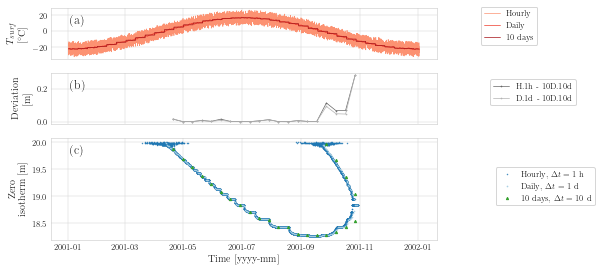

In [18]:
line_w = 0.7
marker_s = 1.3

color_H = '#1f78b4'
color_D =  '#a6cee3'#'#74add1'
color_10D = '#33a02c'  #'#b2df8a'

color_T_H = '#fc9272' #'#f4a582'
color_T_D = '#ef3b2c' #'#b2182b'
color_T_10D = '#a50f15' #'#67001f'

start_date = '2001-01-01'
end_date = '2002-01-01'

fig, ax = plt.subplots(3, 1, sharex='col', gridspec_kw={'height_ratios': [1,1, 2]},figsize=(plot_width,plot_width/1.618))

ax[0].plot(df_Tsurf_H[start_date:end_date]  -273.15, label='Hourly' , color=color_T_H  , linewidth=line_w)
ax[0].plot(df_Tsurf_D[start_date:end_date]  -273.15, label='Daily'  , color=color_T_D  , linewidth=line_w)
ax[0].plot(df_Tsurf_10D[start_date:end_date]-273.15, label='10 days', color=color_T_10D, linewidth=line_w)

ax[0].set_ylabel('$T_{surf}$\n[$^\circ$C]')
ax[0].set_yticks([-20, 0.0, 20])
ax[0].axes.legend(bbox_to_anchor=(1.27,1.1))


ax[1].plot(ds_10D.time.sel(time=slice(start_date, end_date)).values,ds_10D.freezingfrontmaxerrorHH.sel(time=slice(start_date,end_date)).values, label='H.1h - 10D.10d', color='0.4', linewidth=line_w,marker='.',markersize=marker_s)
ax[1].plot(ds_10D.time.sel(time=slice(start_date, end_date)).values,ds_10D.freezingfrontmaxerrorDD.sel(time=slice(start_date,end_date)).values, label='D.1d - 10D.10d', color='0.7', linewidth=line_w,marker='.',markersize=marker_s)
ax[1].set_ylabel('Deviation\n[m]')
ax[1].axes.legend(bbox_to_anchor=(1.37,.95))


lns1 = ax[2].plot(ds_H.time.sel(time=slice(start_date,end_date)).values,ds_H.freezingfronttop.sel(time=slice(start_date,end_date)).values,'.',color=color_H,markersize=0.9)
lns1 = ax[2].plot(ds_H.time.sel(time=slice(start_date,end_date)).values,ds_H.freezingfront.sel(time=slice(start_date,end_date)).values,'.',color=color_H,markersize=0.9,label='Hourly, $\Delta t = 1$ h'  )

lns2 = ax[2].plot(ds_D.time.sel(time=slice(start_date,end_date)).values,ds_D.freezingfronttop.sel(time=slice(start_date,end_date)).values,'.',color=color_D,markersize=marker_s)
lns2 = ax[2].plot(ds_D.time.sel(time=slice(start_date,end_date)).values,ds_D.freezingfront.sel(time=slice(start_date,end_date)).values,'.',color=color_D,markersize=marker_s,label='Daily, $\Delta t = 1$ d'  )

lns3 = ax[2].plot(ds_10D.time.sel(time=slice(start_date,end_date)).values,ds_10D.freezingfronttop.sel(time=slice(start_date,end_date)).values,'^',color=color_10D,markersize=2.3)
lns3 = ax[2].plot(ds_10D.time.sel(time=slice(start_date,end_date)).values,ds_10D.freezingfront.sel(time=slice(start_date,end_date)).values,   '^',color=color_10D,markersize=2.3,label='10 days, $\Delta t = 10$ d'  )


ax[2].set_xlabel('Time [yyyy-mm]')
ax[2].set_ylabel('Zero\nisotherm [m]')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[2].legend(lns, labs, bbox_to_anchor=(1.42,0.75))

plt.text( 0.05,0.7, '(a)', fontsize=12,
             transform=ax[0].transAxes)
plt.text( 0.05,0.7, '(b)', fontsize=12,
             transform=ax[1].transAxes)
plt.text( 0.05,0.85, '(c)', fontsize=12,
             transform=ax[2].transAxes)

plt.show()

### Detail of the beginnig of the thawing season 2001

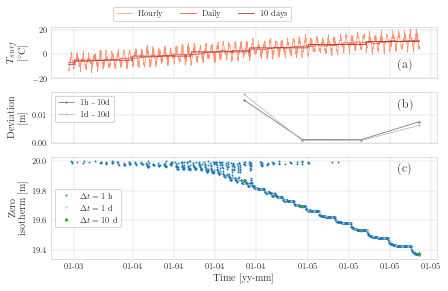

In [19]:
# line_w = 0.7
marker_s = 1.3

color_H = '#1f78b4'
color_D =  '#a6cee3'
color_10D = '#33a02c'  

color_T_H = '#fc9272' 
color_T_D = '#ef3b2c' 
color_T_10D = '#a50f15' 

start_date = '2001-03-21'
end_date = '2001-05-20 00:00'

fig, ax = plt.subplots(3, 1, sharex='col', gridspec_kw={'height_ratios': [1,1,2]},figsize=(plot_width,plot_width/1.618))

ax[0].plot(df_Tsurf_H[start_date:end_date]  -273.15, label='Hourly' , color=color_T_H  , linewidth=line_w)
ax[0].plot(df_Tsurf_D[start_date:end_date]  -273.15, label='Daily'  , color=color_T_D  , linewidth=line_w)
ax[0].plot(df_Tsurf_10D[start_date:end_date]-273.15, label='10 days', color=color_T_10D, linewidth=line_w)

ax[0].set_ylabel('$T_{surf}$\n[$^\circ$C]')
ax[0].set_yticks([-20, 0.0, 20])
ax[0].axes.legend(bbox_to_anchor=(0.15,1.04), loc="lower left",ncol=3,frameon=True)


ax[1].plot(ds_10D.time.sel(time=slice(start_date, end_date)).values, ds_10D.freezingfrontmaxerrorHH.sel(time=slice(start_date,end_date)).values, label='1h - 10d', color='0.4', linewidth=line_w,marker='.',markersize=2.0)
ax[1].plot(ds_10D.time.sel(time=slice(start_date, end_date)).values, ds_10D.freezingfrontmaxerrorDD.sel(time=slice(start_date,end_date)).values, label='1d - 10d', color='0.7', linewidth=line_w,marker='.',markersize=2.0)

ax[1].set_ylabel('Deviation\n[m]')
ax[1].axes.legend(loc='upper left')


lns1 = ax[2].plot(ds_H.time.sel(time=slice(start_date,end_date)).values, ds_H.freezingfronttop.sel(time=slice(start_date,end_date)).values, '.', color=color_H, markersize=1.8)
lns1 = ax[2].plot(ds_H.time.sel(time=slice(start_date,end_date)).values, ds_H.freezingfront.sel(time=slice(start_date,end_date)).values   , '.', color=color_H, markersize=1.8, label='$\Delta t = 1$ h'  )

lns2 = ax[2].plot(ds_D.time.sel(time=slice(start_date,end_date)).values, ds_D.freezingfronttop.sel(time=slice(start_date,end_date)).values, '.', color=color_D, markersize=2.3)
lns2 = ax[2].plot(ds_D.time.sel(time=slice(start_date,end_date)).values, ds_D.freezingfront.sel(time=slice(start_date,end_date)).values   , '.', color=color_D, markersize=2.3, label='$\Delta t = 1$ d'  )

lns3 = ax[2].plot(ds_10D.time.sel(time=slice(start_date,end_date)).values, ds_10D.freezingfronttop.sel(time=slice(start_date,end_date)).values, '^', color=color_10D, markersize=2.5)
lns3 = ax[2].plot(ds_10D.time.sel(time=slice(start_date,end_date)).values, ds_10D.freezingfront.sel(time=slice(start_date,end_date)).values   , '^', color=color_10D, markersize=2.5,   label='$\Delta t = 10$ d'  )


ax[2].set_xlabel('Time [yy-mm]')
ax[2].set_ylabel('Zero\nisotherm [m]')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[2].legend(lns, labs, loc='center left')

plt.text( 0.9,0.2, '(a)', fontsize=12,
             transform=ax[0].transAxes)
plt.text( 0.9,0.7, '(b)', fontsize=12,
             transform=ax[1].transAxes)
plt.text( 0.9,0.85, '(c)', fontsize=12,
             transform=ax[2].transAxes)

plt.show()


### Detail of the beginnig of the freezing season 2001

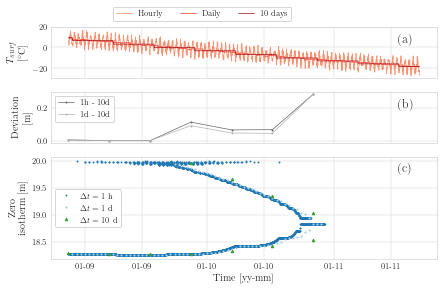

In [20]:
# line_w = 0.7
marker_s = 1.3

color_H = '#1f78b4'
color_D =  '#a6cee3'#'#74add1'
color_10D = '#33a02c'  #'#b2df8a'

color_T_H = '#fc9272' #'#f4a582'
color_T_D = '#ef3b2c' #'#b2182b'
color_T_10D = '#a50f15' #'#67001f'

start_date = '2001-08-28'
end_date = '2001-11-22 00:00'

fig, ax = plt.subplots(3, 1, sharex='col', gridspec_kw={'height_ratios': [1,1,2]},figsize=(plot_width,plot_width/1.618))

ax[0].plot(df_Tsurf_H[start_date:end_date]  -273.15, label='Hourly' , color=color_T_H  , linewidth=line_w)
ax[0].plot(df_Tsurf_D[start_date:end_date]  -273.15, label='Daily'  , color=color_T_D  , linewidth=line_w)
ax[0].plot(df_Tsurf_10D[start_date:end_date]-273.15, label='10 days', color=color_T_10D, linewidth=line_w)

ax[0].set_ylabel('$T_{surf}$\n[$^\circ$C]')
ax[0].set_yticks([-20, 0.0, 20])
ax[0].axes.legend(bbox_to_anchor=(0.15,1.04), loc="lower left",ncol=3,frameon=True)


ax[1].plot(ds_10D.time.sel(time=slice(start_date, end_date)).values, ds_10D.freezingfrontmaxerrorHH.sel(time=slice(start_date,end_date)).values, label='1h - 10d', color='0.4', linewidth=line_w,marker='.',markersize=2.0)
ax[1].plot(ds_10D.time.sel(time=slice(start_date, end_date)).values, ds_10D.freezingfrontmaxerrorDD.sel(time=slice(start_date,end_date)).values, label='1d - 10d', color='0.7', linewidth=line_w,marker='.',markersize=2.0)

ax[1].set_ylabel('Deviation\n[m]')
ax[1].axes.legend(loc='upper left')


lns1 = ax[2].plot(ds_H.time.sel(time=slice(start_date,end_date)).values, ds_H.freezingfronttop.sel(time=slice(start_date,end_date)).values, '.', color=color_H, markersize=1.8)
lns1 = ax[2].plot(ds_H.time.sel(time=slice(start_date,end_date)).values, ds_H.freezingfront.sel(time=slice(start_date,end_date)).values   , '.', color=color_H, markersize=1.8, label='$\Delta t = 1$ h'  )

lns2 = ax[2].plot(ds_D.time.sel(time=slice(start_date,end_date)).values, ds_D.freezingfronttop.sel(time=slice(start_date,end_date)).values, '.', color=color_D, markersize=2.3)
lns2 = ax[2].plot(ds_D.time.sel(time=slice(start_date,end_date)).values, ds_D.freezingfront.sel(time=slice(start_date,end_date)).values   , '.', color=color_D, markersize=2.3, label='$\Delta t = 1$ d'  )

lns3 = ax[2].plot(ds_10D.time.sel(time=slice(start_date,end_date)).values, ds_10D.freezingfronttop.sel(time=slice(start_date,end_date)).values, '^', color=color_10D, markersize=2.5)
lns3 = ax[2].plot(ds_10D.time.sel(time=slice(start_date,end_date)).values, ds_10D.freezingfront.sel(time=slice(start_date,end_date)).values   , '^', color=color_10D, markersize=2.5,   label='$\Delta t = 10$ d'  )


ax[2].set_xlabel('Time [yy-mm]')
ax[2].set_ylabel('Zero\nisotherm [m]')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[2].legend(lns, labs, loc='center left')

plt.text( 0.9,0.7, '(a)', fontsize=12,
             transform=ax[0].transAxes)
plt.text( 0.9,0.7, '(b)', fontsize=12,
             transform=ax[1].transAxes)
plt.text( 0.9,0.85, '(c)', fontsize=12,
             transform=ax[2].transAxes)

plt.show()

## Thermal offset and the zero-curtain effect

In [21]:
os.chdir(oms_project_path + '/output')
# os.listdir()

In [22]:
%%time
with xr.open_dataset('ThermalOffset_finegrid_H.nc', engine='scipy') as ds_H:
    print('read ds_H') 
    
with xr.open_dataset('ThermalOffset_finegrid_D.nc', engine='scipy') as ds_D:
    print('read ds_D')

with xr.open_dataset('ThermalOffset_finegrid_10D.nc', engine='scipy') as ds_10D:
    print('read ds_10D')


read ds_H
read ds_D
read ds_10D
Wall time: 1min 45s


In [23]:
T_mean_H = ds_H.T.mean(dim='time')
T_max_H = ds_H.T.max(dim='time')
T_min_H = ds_H.T.min(dim='time')

T_mean_D = ds_D.T.mean(dim='time')
T_max_D = ds_D.T.max(dim='time')
T_min_D = ds_D.T.min(dim='time')

T_mean_10D = ds_10D.T.mean(dim='time')
T_max_10D = ds_10D.T.max(dim='time')
T_min_10D = ds_10D.T.min(dim='time')

eta = 20 - ds_H.z.values[:]

## Temperature evolope for the three simulations

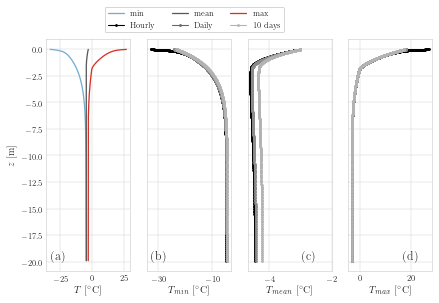

In [24]:
line_w = 1.1
line_w_1 = 1.3
marker_s = 3.5

fig, ax = plt.subplots(1, 4, sharey='row', figsize=(plot_width,plot_width/1.618))


lns1 = ax[0].plot(T_min_H.values -273.15 ,  -eta, color='#74add1'  , linewidth=line_w_1, marker='.', markersize=0., label='min')
lns2 = ax[0].plot(T_mean_H.values -273.15,  -eta, color='0.35'     , linewidth=line_w_1, marker='.', markersize=0.,label='mean')
lns3 = ax[0].plot(T_max_H.values-273.15  ,  -eta, color='#d73027'  , linewidth=line_w_1, marker='.', markersize=0.,label='max')
ax[0].set_xlabel('$T$ [$^\circ$C]')
ax[0].set_ylabel('$z$ [m]')

lns4 = ax[1].plot(T_min_H.values-273.15  ,  -eta, color='k'   , linewidth=line_w, marker='.', markersize=marker_s)
lns5 = ax[1].plot(T_min_D.values-273.15  ,  -eta, color='0.55', linewidth=line_w, marker='.', markersize=marker_s)
lns6 = ax[1].plot(T_min_10D.values-273.15,  -eta, color='0.7' , linewidth=line_w, marker='.', markersize=marker_s)
ax[1].set_xlabel('$T_{min}$ [$^\circ$C]')
ax[1].set_xticks([-30,-10])


ax[2].plot(T_mean_H.values-273.15  ,  -eta, color='k'   , linewidth=line_w, marker='.', markersize=marker_s)
ax[2].plot(T_mean_D.values-273.15  ,  -eta, color='0.55', linewidth=line_w, marker='.', markersize=marker_s)
ax[2].plot(T_mean_10D.values-273.15,  -eta, color='0.7' , linewidth=line_w, marker='.', markersize=marker_s)
ax[2].set_xticks([-4,-2])
ax[2].set_xlabel('$T_{mean}$ [$^\circ$C]')


ax[3].plot(T_max_H.values-273.15  ,  -eta, color='k'   , linewidth=line_w, marker='.', markersize=marker_s)
ax[3].plot(T_max_D.values-273.15  ,  -eta, color='0.55', linewidth=line_w, marker='.', markersize=marker_s)
ax[3].plot(T_max_10D.values-273.15,  -eta, color='0.7' , linewidth=line_w, marker='.', markersize=marker_s)
ax[3].set_xlabel('$T_{max}$ [$^\circ$C]')

# line_w_1 = 0.7
# line_w = 0.2
# marker_s = 0.8
lns1 = plt.plot(np.nan,np.nan, color='#74add1'  , linewidth=line_w_1, marker='.', markersize=0.      , label='min')
lns2 = plt.plot(np.nan,np.nan, color='k'        , linewidth=line_w  , marker='.', markersize=marker_s, label='Hourly')
lns3 = plt.plot(np.nan,np.nan, color='0.35'     , linewidth=line_w_1, marker='.', markersize=0.      , label='mean')
lns4 = plt.plot(np.nan,np.nan, color='0.4'      , linewidth=line_w  , marker='.', markersize=marker_s, label='Daily')
lns5 = plt.plot(np.nan,np.nan, color='#d73027'  , linewidth=line_w_1, marker='.', markersize=0.      , label='max')
lns6 = plt.plot(np.nan,np.nan, color='0.7'      , linewidth=line_w  , marker='.', markersize=marker_s, label='10 days')


lns = lns1+lns2+lns3+lns4+lns5+lns6
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.65,1.01), ncol=3, loc='lower left', frameon=True)

plt.text( 0.05,0.05, '(a)', fontsize=12,
             transform=ax[0].transAxes)
plt.text( 0.05,0.05, '(b)', fontsize=12,
             transform=ax[1].transAxes)
plt.text( 0.65,0.05, '(c)', fontsize=12,
             transform=ax[2].transAxes)
plt.text( 0.65,0.05, '(d)', fontsize=12,
             transform=ax[3].transAxes)

plt.show()

Looking at (a) the envelope of the maximum temperature present an 'elbow' that can be explained with the zero-curtain effect

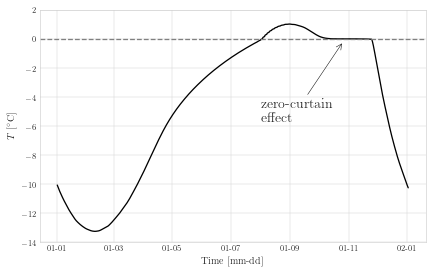

In [25]:

line_w = 1.3
fig, ax = plt.subplots(1, 1, figsize=(plot_width,plot_width/1.618))
start_date = '2001-01-01'
end_date = '2002-01-01'
plt.plot(ds_H.time.sel(time=slice(start_date,end_date)),ds_H.T.sel(z=18.5,method='nearest').sel(time=slice(start_date,end_date))-273.15, linewidth= line_w, color='k')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))

ax.annotate(s='zero-curtain\n effect', fontsize=14, xy=(datetime.date(2001,10,26),-0.2), xytext=(datetime.date(2001,8,1),-5),arrowprops={'arrowstyle':'->','lw': 0.5, 'ec': 'k'},va='center')
plt.axhline(0.0,linewidth=line_w, linestyle='--',color='0.5')
ax.set_ylim(-14,2)

plt.ylabel('$T$ [$^\circ$C]')
plt.xlabel('Time [mm-dd]')

plt.show()

## Temperature evolope for the three simulations considering $\lambda_w=\lambda_i$